<a href="https://colab.research.google.com/github/MoritzLaurer/zeroshot-classifier/blob/main/5_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualisation of Results
We download the metrics from the training and evaluation run stored via Weights & Biases and visualise the results for each task.

### Installation and setup

In [ ]:
!pip install wandb~=0.15.0 -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


In [ ]:
## connect to google drive
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=False)

#set wd
print(os.getcwd())
os.chdir("/content/drive/My Drive/PhD/zero-shot-models")
print(os.getcwd())

# local config.py file with tokens
import config

os.environ["WANDB_API_KEY"] = config.WANDB_ACCESS_TOKEN

Mounted at /content/drive
/content
/content/drive/My Drive/PhD/zero-shot-models


### Download and format data

In [ ]:
# download metrics from weights & biases
# test download wandb data
# docs: https://docs.wandb.ai/guides/track/public-api-guide
import pandas as pd
import wandb

tasks_not_nli = [
    'amazonpolarity', 'imdb', 'appreviews', 'yelpreviews', 'rottentomatoes',
    'emotiondair', 'emocontext', 'empathetic',
    'financialphrasebank', 'banking77', 'massive',
    'wikitoxic_toxicaggregated', 'wikitoxic_obscene', 'wikitoxic_threat', 'wikitoxic_insult', 'wikitoxic_identityhate',
    'hateoffensive', 'hatexplain', 'biasframes_offensive', 'biasframes_sex', 'biasframes_intent',
    'agnews', 'yahootopics',
    'trueteacher', 'spam', 'wellformedquery',
    # added for v1.1
    "manifesto", "capsotu"
]
tasks_nli = ["mnli_m", "mnli_mm", "fever", "anli_r1", "anli_r2", "anli_r3", "wanli", "ling"]
tasks_lst = tasks_not_nli + tasks_nli



api = wandb.Api()
entity, project = "moritzlaurer", "nli-zeroshot-20231109"
runs = api.runs(entity + "/" + project)

metric_to_extract = "accuracy_balanced"

config_list, name_list, metrics_dic = [], [], {}
for run in runs:
    print("wandb.run.name: ", run.name)
    print("wandb.run.id: ", run.id)

    # extract specific metrics
    metrics = {}
    for task in tasks_lst:
        for i, row in run.history(keys=[f"{task}.eval_{metric_to_extract}"]).iterrows():
            metrics.update({task: row[f"{task}.eval_{metric_to_extract}"]})
    metrics_dic.update({run.name: metrics})

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
         if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

metrics_dic


wandb.run.name:  DeBERTa-v3-base-mnli-fever-docnli-ling-2c-zeroshot-2023-11-09-15-00
wandb.run.id:  928tempp
wandb.run.name:  deberta-v3-base-zeroshot-2023-11-09-14-38
wandb.run.id:  aoly4a2k


{'DeBERTa-v3-base-mnli-fever-docnli-ling-2c-zeroshot-2023-11-09-15-00': {'amazonpolarity': 0.8955,
  'imdb': 0.8633,
  'appreviews': 0.893,
  'yelpreviews': 0.9069,
  'rottentomatoes': 0.75046904315197,
  'emotiondair': 0.48529908908110553,
  'emocontext': 0.5465359904121395,
  'empathetic': 0.2311229507663507,
  'financialphrasebank': 0.6575092216171708,
  'banking77': 0.24571785818130445,
  'massive': 0.47783721935580986,
  'wikitoxic_toxicaggregated': 0.802,
  'wikitoxic_obscene': 0.8173568409645082,
  'wikitoxic_threat': 0.6673,
  'wikitoxic_insult': 0.7044606944849723,
  'wikitoxic_identityhate': 0.791023595505618,
  'hateoffensive': 0.5629032258064516,
  'hatexplain': 0.47986239950525666,
  'biasframes_offensive': 0.598358051067759,
  'biasframes_sex': 0.8088072249868856,
  'biasframes_intent': 0.5810322299651568,
  'agnews': 0.763421052631579,
  'yahootopics': 0.47102000000000005,
  'trueteacher': 0.5101372985247302,
  'spam': 0.5101246368979261,
  'wellformedquery': 0.533500245

In [ ]:

# rename some tasks
map_rename_tasks = {
    "mnli_m": "mnli_m_binary", "mnli_mm": "mnli_mm_binary",
    "fever": "fever_nli_binary", "anli_r1": "anli_r1_binary",
    "anli_r2": "anli_r2_binary", "anli_r3": "anli_r3_binary",
    "wanli": "wanli_binary", "ling": "ling_nli_binary"
}
for run  in metrics_dic:
    metrics_dic[run] = {map_rename_tasks.get(k, k): v for k, v in metrics_dic[run].items()}

# names in order of runs (!)
print(f"Old run names: {metrics_dic.keys()}")
new_run_names = ["deberta-v3-base-nli", "deberta-v3-base-zeroshot"]
metrics_dic = dict(zip(new_run_names, metrics_dic.values()))
print(f"New run names: {metrics_dic.keys()}")



### Visualize

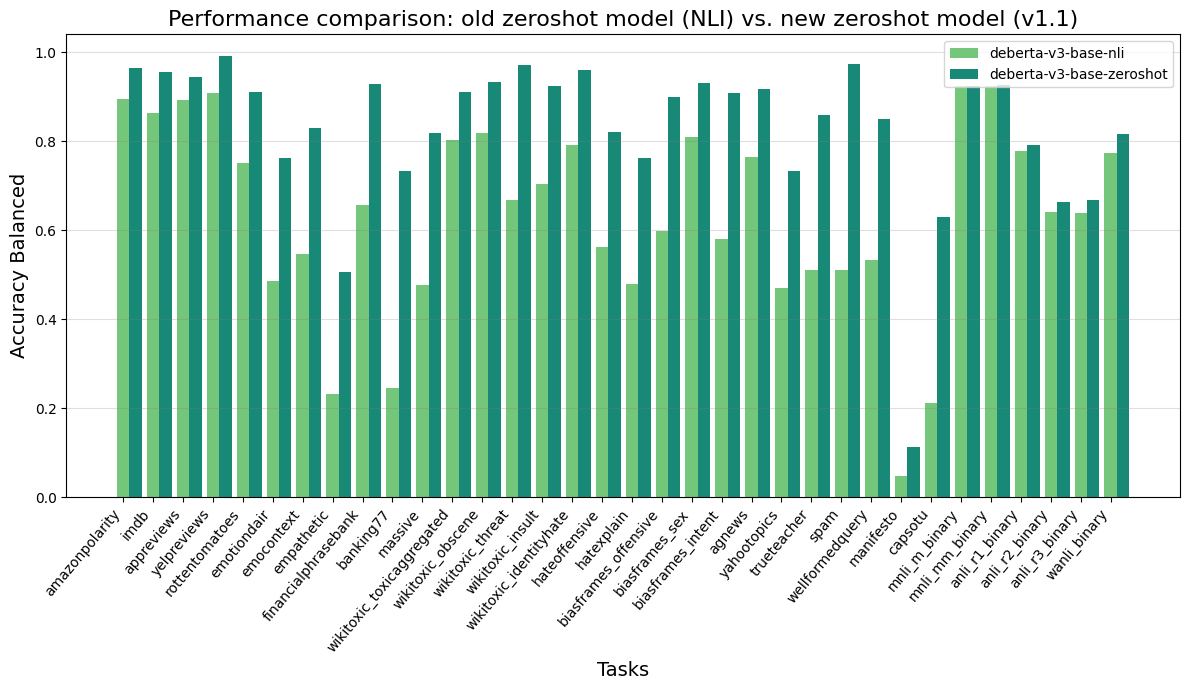

In [ ]:
import matplotlib.pyplot as plt

dataset_names = list(metrics_dic[list(metrics_dic.keys())[0]].keys())

# Set up the plotting parameters
width = 0.25
gap = 0.10  # spacing between groups
group_width = len(metrics_dic) * width + (len(metrics_dic) - 1) * gap

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 7))
colors = ["#74C67A", "#188977"]  # "#222839"

for i, (key_run_name, values) in enumerate(metrics_dic.items()):
    # Create an x-axis position for each bar
    x_positions = [j * group_width + i * width for j in range(len(values))]
    # Plot the bars
    ax.bar(x_positions, list(values.values()), width, label=key_run_name, color=colors[i])

# Adjust x-axis ticks
ax.set_xticks([i * group_width for i in range(len(dataset_names))])
ax.set_xticklabels(dataset_names, rotation=50, ha='right', fontsize=10)
ax.set_xlabel('Tasks', fontsize=14)
ax.set_ylabel(metric_to_extract, fontsize=14)
ax.set_title('Performance comparison: old zeroshot model (NLI) vs. new zeroshot model (v1.1)', fontsize=16)
ax.legend()
ax.yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=.25)
fig.tight_layout()

# Show the plot
plt.show()
